In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest

import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [2]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [3]:
all_proteins = list(proteomics.columns.values)

In [4]:
phosProtList = all_proteins

In [5]:
sites = phos.columns
p_values = []
site_names = []
gene = 'ARID1A'

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            '''Just making sure not to do comparison on mutation column'''
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
                '''Compare mutated with wildtype using a t-test'''
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  5.191461084807708e-07


In [8]:
for key in sorted(bf_significant_vals):
    #print(%s: %s % (key, bf_significant_vals[key]))
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))

ARID1A-S1184 1.0349980050963608e-07
ARID1A-S1604 1.9926532216398217e-07
ARID1A-S1755 4.012400598928052e-09
9
9
96312


# Plot phosphorylation levels

## ARID1A-S1184

### All mutation types

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

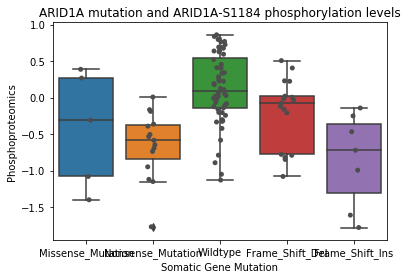

In [12]:
gene = "ARID1A"
site = "ARID1A-S1184"

genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Mutation vs Wildtype

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

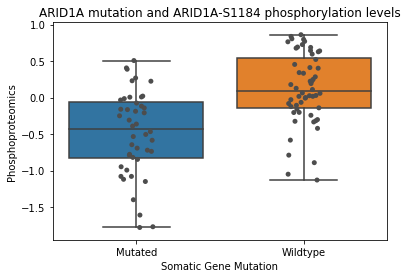

In [11]:
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

## ARID1A-S1604

### All Mutation Types

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

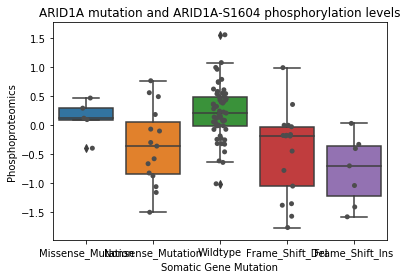

In [14]:
site = "ARID1A-S1604"

genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Mutation vs Wildtype

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

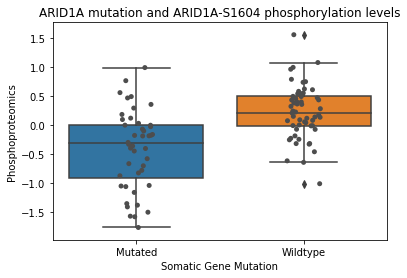

In [15]:
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

## ARID1A-S1755

### All mutation types

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

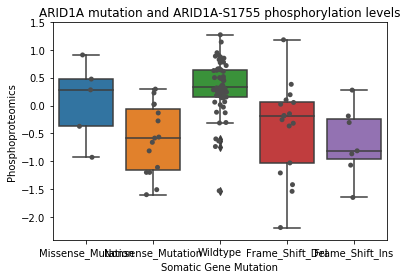

In [16]:
site = "ARID1A-S1755"

genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Mutation vs Wildtype

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

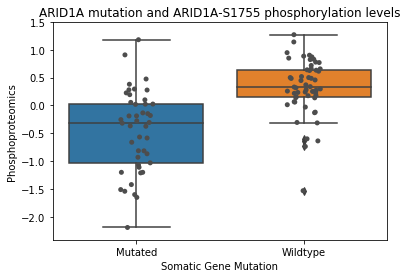

In [17]:
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")